## Dynamics of the COVID-19 infection

### 0. Setup and imports

In [6]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### 1. Models for the simulation of the COVID-19 Pandemic

As the current Sars-CoV-2 Pandemic unfolds, research groups around the world are trying to model the dynamics of the ongoing Pandemic. Epediemiological models are needed to forecast the infections, guide policy makers and probe interventions measures. Even though multiple approaches have been implemented to elucidate different facets of the Pandemic, most models are based on the same SEIR [2] framework. The population of interest is seperated into different compartements, based on theil contact with the pathogen. Susceptible (S) People can become exposed (E), which can lead to an succsesfull infection with the virus. Infected (I) Population can then further infect susceptible indivisuals until recovery (R). As described the SEIR model assumes immunity after overcomming the infection.

$
\newcommand{ptr}[1]{\overset{\mathtt{#1}}{\longrightarrow}}                                  
                                             \fbox{S(t)}  \ptr{exposition}
                                              \fbox{E(t)}    \ptr{infection}
                                              \fbox{I(t)}     \ptr{recovery}
                                             \fbox{R(t)}
$
<br><br>
We implemented two different model, which are both extending this concept.

##### The Neher Model - COVID-19 Dynamics
The research group from the Swiss Institute of Bioinformatics, led by Richard Neher, developed a model to simulate the current Sars-CoV-2 Pandemic [1]. The Model is based on the described SEIR  framework, which was extended to account for the specific questions of interest in the current Pandemic. A special focus was set to asses the strain on the healthcare system and to model the capacity overflow on ICU units. Furthermore, the effect on different age groups can be assessed and the isolation of age groups can be modeled with high fidelity. and the effect of seasonal forcing on the spread of infection can be simulated [3]. The model was published as an interactive web application which freely accessible and lets the user explore fitted parameters based on observational data and custom parameters [4]. 

##### The Colizza Model
Another group of researchers arround Laura Di Domenico from the INSERM [5] also created a model to describe the Sars-CoV-2 Pandemic. The base for the model is also a modified SEIR framework. It is extended to bring in the contacts between people and the different behaviours of infected perople into calculation.  
At the moment, europe and the world are currently under strict social distancing measures. It is not clear, how the different countries can reduce the strict counter measures against the virus, without running into a second wave.  
Therefor the paper addresses the question, what influence have the applied counter measures on the development of the pandemi and what are possible exit strategies to get out of the lockdown in a save way.  
The paper is published as a pre-print and publicly available [6]. It contains information about the model and the used parameter but does not publish the sources.

### 2.1. The Neher model, modeling the health system strain and ICU Overflow



### 2.2. Parameters and compartments of the model

### 2.3. Implementation of the model

### 3. The Colizza Model, simulating contact behaviour

The model expandet SEIR model and includes multiple states infection states ($I$).
The state is split into the prodromic phase ($I_p$), followed by four states, repersenting the severity of  Asymptomatic Infectious state ($I_{a}$), Paucysymptomatic Infectious($I_{ps}$), Symptomatic Infectious ($I_{ms}$) and the state for Symptomatic Infectious with severe symptoms ($I_{ss}$).  
The first three states show a mild course after infection. The different states are used to model the behaviour of affected people in more detail. With the parameters it is possible to represent the selfisolation because of the illness. It is assumed that, during a sever illness, people reduce their contacts by 75% [7].  
All people in state $I_{ss}$ have a stay in the hospital, either in the normal tracks or in the ICU.  
These last two states help to analyse, if a counter measure is enough to prevent the health care system from collapsing.  
The compartmental model was initialy build based on French hospital data APHP (Assistance publique - Hôpitaux de Paris[8]).
Afterwards it was rescaled to fit whole Île-de-France region.  
The paper separates the population into three groups, children (c), adults (a) and seniors(s). Each group interacts with the others, but has a different contact level.


The general model is shown in Figure 1:

Graph, Fig 1

It can be described as a system of first order ordinary differential equations:

$$
\begin{align*}
    \frac{dS}{dt} = -b * S *(I_{p} + I_{a} + I_{ps} + I_{ms} + I_{ss})\\
    \frac{dE}{dt}=b * S * (I_{p} + I_{a} + I_{ps} + I_{ms} + I_{ss}) -e * E\\
    \frac{dI_{p}}{dt}=e*E - u_{p} * I_{p}\\
    \frac{dI_{a}}{dt}=p_{a}*u_{p}*I_{p} - u * I_{a}\\
    \frac{dI_{ps}}{dt}=(1-p_{a}) * p_{ps} * u_{p} * I_{p} - u * I_{ps}\\
    \frac{dI_{ms}}{dt}=(1-p_{a})* p_{ms} * u_{p} * I_{p} - u * I_{ms}\\
    \frac{dI_{ss}}{dt}=(1-p_{a})* p_{ss} * u_{p} * I_{p} - u * I_{ss}\\
    \frac{dH}{dt}=(1 - p_{ICU}) * u * I_{ss} - (\lambda_{H,R} + \lambda_{H,D}) * H\\
    \frac{dI_{ICU}}{dt}=p_{ICU} * u * I_{ss} - (\lambda_{ICU,R} + \lambda_{ICU,D}) * ICU\\
    \frac{dR}{dt}=u * (I_{a} + I_{ps} + I_{ms}) + l_{H,R} * H + l_{ICU,R} * ICU \\
    \frac{dD}{dt}l_{H,D} * H + l_{ICU,D} * ICU
\end{align*}
$$

To get a better understanding of the ODE system the different  population groups were not included in this table. In the implementation all three classes are used.

#### 3.1 Creating the contact matrix

The main contact matrix influencing the model is based on multiple contact matrices. Each matrix represents a given situation of the daily life and has its own amount of contacts between the different groups.  
The researchers devided the daily life in six different parts, each with a different ratio. As a result, we have six matrices: $K_{household}$, $K_{school}$, $K_{workplace}$, $K_{transport}$, $K_{leisure}$ and $K_{other}$.


To get our input matrix $K$ for the model, we can use the weighted sum of all matrices:
$$K=\sum{K_{place}*ratio_{place}}$$

To show the importance of this contact matrices, we created one baseline matrix $K_{baseline}$ and one matrix to decribe the influence of the counter measures $K_{measure}$.

The contact matrix is organized that $K_{00}$ represents the contacts from children to children, $K_{01}$ from adults to children and so on.
$$K=
\begin{pmatrix}
    c\rightarrow c && a\rightarrow c && s\rightarrow c\\
    c\rightarrow a && a\rightarrow a && s\rightarrow a\\
    c\rightarrow s && a\rightarrow s && s\rightarrow s
\end{pmatrix}
$$

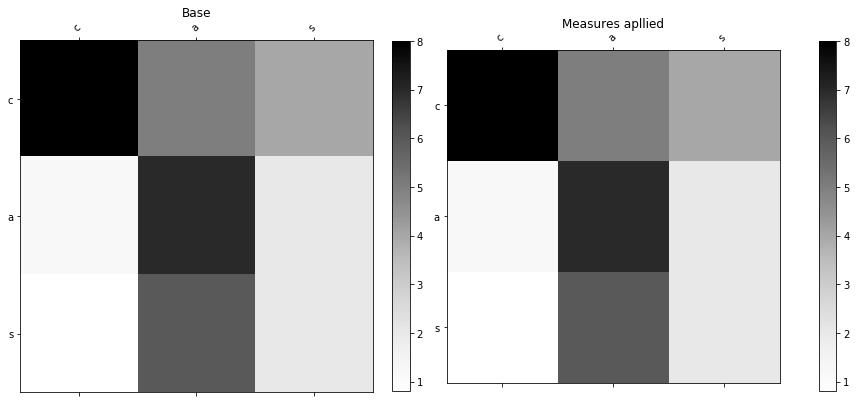

In [10]:
# baseline
ratioBase_household = 1/6
ratioBase_school = 1/6
ratioBase_workplace = 1/6
ratioBase_transport = 1/6
ratioBase_leisure = 1/6
ratioBase_other = 1/6

kBase_household = [
    [8, 5, 4],  
    [1.2, 7, 2], 
    [0.8, 6, 2]]
kBase_school = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kBase_workplace = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kBase_transport = [
    [8, 5, 4], 
    [1.2, 7, 2],
    [0.8, 6, 2]]
kBase_leisure = [
    [8, 5, 4],
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kBase_other = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 

kBase = [
    [1, 1, 1], 
    [1, 1, 1], 
    [1, 1, 1]] 

# Measure
ratioMeasure_household = 1/6
ratioMeasure_school = 1/6
ratioMeasure_workplace = 1/6
ratioMeasure_transport = 1/6
ratioMeasure_leisure = 1/6
ratioMeasure_other = 1/6

kMeasure_household = [
    [8, 5, 4],  
    [1.2, 7, 2], 
    [0.8, 6, 2]]
kMeasure_school = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kMeasure_workplace = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kMeasure_transport = [
    [8, 5, 4], 
    [1.2, 7, 2],
    [0.8, 6, 2]]
kMeasure_leisure = [
    [8, 5, 4],
    [1.2, 7, 2], 
    [0.8, 6, 2]] 
kMeasure_other = [
    [8, 5, 4], 
    [1.2, 7, 2], 
    [0.8, 6, 2]] 

kMeasure = [
    [1, 1, 1], 
    [1, 1, 1], 
    [1, 1, 1]] 

for i in range(3):
    for j in range(3):
        kBase[i][j] = kBase_household[i][j] * ratioBase_household + kBase_school[i][j] * ratioBase_school \
                      + kBase_workplace[i][j] * ratioBase_workplace + kBase_transport[i][j] * ratioBase_transport \
                      + kBase_leisure[i][j] * ratioBase_leisure + kBase_other[i][j] * ratioBase_other
        
        kMeasure[i][j] = kMeasure_household[i][j] * ratioMeasure_household \
                         + kMeasure_school[i][j] * ratioMeasure_household \
                         + kMeasure_workplace[i][j] * ratioMeasure_workplace \
                         + kMeasure_transport[i][j] * ratioMeasure_transport \
                         + kMeasure_leisure[i][j] * ratioMeasure_leisure \
                         + kMeasure_other[i][j] * ratioMeasure_other
        

# Variation of [9]
# Basic Configuration
fig, axes = plt.subplots(ncols=2, figsize=(12, 12))
ax1, ax2 = axes

# Heat maps.
im1 = ax1.matshow(kBase, cmap='Greys')
im2 = ax2.matshow(kMeasure, cmap='Greys')

# Formatting for heat map 1.
ax1.set_title("Base")
ax1.set_xticks(range(len(kBase)))
ax1.set_yticks(range(len(kBase)))
ax1.set_xticklabels(['c', 'a', 's'])
ax1.set_yticklabels(['c', 'a', 's'])
ax1.set_ylim(len(kBase)-0.5, -0.5)
plt.setp(ax1.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
plt.colorbar(im1, fraction=0.045, pad=0.05, ax=ax1)

# Formatting for heat map 2.
ax2.set_title("Measures apllied")
ax2.set_xticks(range(len(kMeasure)))
ax2.set_yticks(range(len(kMeasure)))
ax2.set_xticklabels(['c', 'a', 's'])
ax2.set_yticklabels(['c', 'a', 's'])
ax2.set_ylim(len(kMeasure)-0.5, -0.5)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='left', rotation_mode='anchor')
plt.colorbar(im2, fraction=0.045, pad=0.1, ax=ax2)

fig.tight_layout()
plt.show()

####  3.2 Parameters for the model

#### 3.3 Implementing the Colizza model

One important part of the model is the separation of the population in three parts (c, a, s). We have different chances in the different groups for the infection rate and the progression.  
To represent this we created one model per group. The only contact between these three models is the infection phase. Children can not only infect other children, but also adults and seniors.

Using a solver for our function *colizzaModel(...)*, we calculate the development of all three population groups.

In [12]:
def casModel1(status, t, b, k, k_i, e, p_a, p_ps, p_ms, p_ss, u_p, u, p_icu, l_hr, l_hd, l_icur, l_icud):
    # re-create vectors per population group
    S = np.empty(3, dtype=float)
    E = np.empty(3, dtype=float)
    I_p = np.empty(3, dtype=float)
    I_a = np.empty(3, dtype=float)
    I_ps = np.empty(3, dtype=float)
    I_ms = np.empty(3, dtype=float)
    I_ss = np.empty(3, dtype=float)
    H = np.empty(3, dtype=float)
    ICU = np.empty(3, dtype=float)
    R = np.empty(3, dtype=float)
    D = np.empty(3, dtype=float)
    
    for i in range(3):
        S[i] = status[0 + i]
        E[i] = status[3 + i]
        I_p[i] = status[6 + i]
        I_a[i] = status[9 + i]
        I_ps[i] = status[12 + i]
        I_ms[i] = status[15 + i]
        I_ss[i] = status[18 + i]
        H[i] = status[21 + i]
        ICU[i] = status[24 + i]
        R[i] = status[27 + i]
        D[i] =status[ 30 + i]
    
    #prepare return arrays
    dSdT = np.empty(3, dtype=float)
    dEdT = np.empty(3, dtype=float)
    dI_pdT = np.empty(3, dtype=float)
    dI_adT = np.empty(3, dtype=float)
    dI_psdT = np.empty(3, dtype=float)
    dI_msdT = np.empty(3, dtype=float)
    dI_ssdT = np.empty(3, dtype=float)
    dHdT = np.empty(3, dtype=float)
    dICUdT = np.empty(3, dtype=float)
    dRdT = np.empty(3, dtype=float)
    dDdT = np.empty(3, dtype=float)
    
    # Define ODE system
    for i in range(3):     
        dSdT[i] = -b[i] * S[i] * (k[0][i] * (I_p[0] + k_i[0] * I_a[0] + k_i[1] * I_ps[0] + k_i[2] * I_ms[0] + k_i[3] * I_ss[0] ) \
                                  + k[1][i] * (I_p[1] + k_i[0] * I_a[1] + k_i[1] * I_ps[1] + k_i[2] * I_ms[1] + k_i[3] * I_ss[1] ) \
                                  + k[2][i] * (I_p[2] + k_i[0] * I_a[2] + k_i[1] * I_ps[2] + k_i[2] * I_ms[2] + k_i[3] * I_ss[2] ))
        dEdT[i] = - e[i] * E[i] \
                  + b[i] * S[i] * (k[0][i] * (I_p[0] + k_i[0] * I_a[0] + k_i[1] * I_ps[0] + k_i[2] * I_ms[0] + k_i[3] * I_ss[0] ) \
                                 + k[1][i] * (I_p[1] + k_i[0] * I_a[1] + k_i[1] * I_ps[1] + k_i[2] * I_ms[1] + k_i[3] * I_ss[1] ) \
                                 + k[2][i] * (I_p[2] + k_i[0] * I_a[2] + k_i[1] * I_ps[2] + k_i[2] * I_ms[2] + k_i[3] * I_ss[2] )) \
                
        
        dI_pdT[i] = e[i] * E[i] - u_p[i]* (p_a[i]  + (1 - p_a[i]) * (p_ps[i] + p_ms[i] + p_ss[i])) * I_p[i] 
        dI_adT[i] = p_a[i] * u_p[i] * I_p[i] - u[i] * I_a[i]
        dI_psdT[i] = (1 - p_a[i]) * p_ps[i] * u _p[i] * I_p[i] - u[i] * I_ps[i]
        dI_msdT[i] = (1 - p_a[i]) * p_ms[i] * u_p[i] * I_p[i] - u[i] * I_ms[i]
        dI_ssdT[i] = (1 - p_a[i]) * p_ss[i] * u_p[i] * I_p[i] - u[i] * I_ss[i]    
        dHdT[i] = (1 - p_icu[i]) * u[i] * I_ss[i] - (l_hr[i] + l_hd[i]) * H[i]
        dICUdT[i] = p_icu[i] * u[i] * I_ss[i] - (l_icur[i] + l_icud[i]) * ICU[i]   
        dRdT[i] = u[i] * (I_a[i] + I_ps[i] + I_ms[i]) + l_hr[i] * H[i] + l_icur[i] * ICU[i] 
        dDdT[i] = l_hd[i] * H[i] + l_icud[i] * ICU[i]
    
    # return flattened arrays
    return [dSdT[0], dSdT[1], dSdT[2], dEdT[0], dEdT[1], dEdT[2], dI_pdT[0], dI_pdT[1], dI_pdT[2], dI_adT[0], dI_adT[1], dI_adT[2], dI_psdT[0], dI_psdT[1], dI_psdT[2], dI_msdT[0], dI_msdT[1], dI_msdT[2], dI_ssdT[0], dI_ssdT[1], dI_ssdT[2], dHdT[0], dHdT[1], dHdT[2], dICUdT[0], dICUdT[1], dICUdT[2], dRdT[0], dRdT[1], dRdT[2], dDdT[0], dDdT[1], dDdT[2] ]

SyntaxError: invalid syntax (<ipython-input-12-230856e66aab>, line 54)

### 4.1 Results from the Neher model

### 4.2 Results from the Colizza model

### 4.3 Two similar approaches with different focus - comparison of the Coliza and Neher model

### 5. Appendix 

[5] INSERM, Sorbonne Université, Pierre Louis Institute of Epidemiology and Public Health, Paris, France  
[6] Di Domenico et al,Expected impact of lockdown in Ile-de-France and possible exit strategies, Report #9, medRxiv.org  
[7] Van Kerckhove, K., Hens, N., Edmunds, W. J. & Eames, K. T. D. The Impact of Illness on Social Networks: Implications for Transmission and Control of Influenza. Am. J. Epidemiol. 178, 1655– 1662 (2013)  
[8] APHP. https://www.aphp.fr/  
[9] https://stackoverflow.com/questions/55663030/plotting-two-heat-maps-side-by-side-in-matplotlib
